In [3]:
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  data = data[data['v'] > 1200]  # Filter out galaxies with negative cz values

  # Create ks column for K-band absolute magnitude
  from astropy.constants import c
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
  comoving_dist = cosmo.comoving_distance((data['v']*u.km/u.s)/c) 
  data['ks']  = data['k_tc'] - 25 - 5*np.log10(comoving_dist.value*(1 + (data['v']*u.km/u.s)/c))  # K-band absolute magnitude

  data['_RAJ2000'] = data['RAdeg']  
  data['_DEJ2000'] = data['DECdeg']  
  data['cz'] = data['v']

  return data

# === Load galaxy catalogue ===
gxs = read_catalog()
gxs = gxs[(gxs['cz']>1200)&(gxs['cz']<2400)]  

# === Load flux cataloge ===
# Load flux data
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]


Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']


In [50]:
import treecorr

gcat = treecorr.Catalog(ra=gxs['_RAJ2000'], dec=gxs['_DEJ2000'],\
                            ra_units='deg', dec_units='deg', npatch=10)

# Ensure flux_val is a valid 1D array
flux_val = np.array(flux_val, dtype=float)  # Convert to float if necessary

fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,\
                            ra_units='deg', dec_units='deg', npatch=10)

In [51]:
def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    rand_ra = np.random.uniform(0, 360, N_total)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))
    return rand_ra, rand_dec

rand_ra, rand_dec = generate_RanCat(len(gxs)*10, dec_min=-90, dec_max=45)
rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                             ra_units='deg', dec_units='deg', npatch=10)

In [67]:
config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 500,
}
nk = treecorr.NKCorrelation(config)
rk = treecorr.NKCorrelation(config)
nk.process(gcat, fcat)
rk.process(rand_cat, fcat)
xi, varxi = nk.calculateXi(rk=rk)
print('xi:', xi)
print('variance:', varxi**0.5)

Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='geom'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.
xi: [ 0.00501426  0.00481576  0.00440562  0.00391653  0.00347943  0.00308682
  0.00266542  0.0022637   0.00183455  0.00130556  0.00085275  0.00035391
 -0.00011027 -0.00052493 -0.00084954]
variance: [0.00673846 0.00651291 0.00618223 0.00583089 0.00544256 0.00505934
 0.00469354 0.00435624 0.00399759 0.00373213 0.00348764 0.00326019
 0.00301671 0.00278989 0.0025595 ]


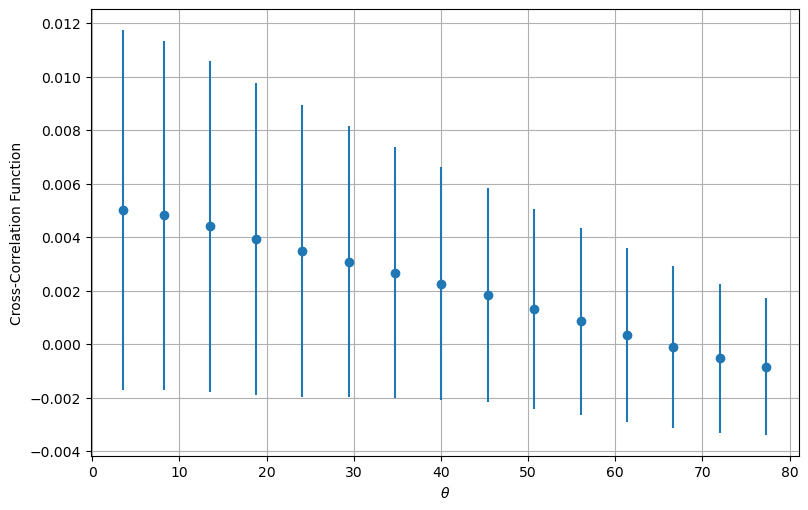

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.errorbar(nk.meanr, xi, yerr=nk.raw_varxi**.5, fmt='o', label='Galaxy-Flux Correlation')
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\theta$')
plt.ylabel('Cross-Correlation Function')
plt.show()

#### Uniendo todo

Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='geom'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.
xi: [ 5.11477439e-03  4.90474833e-03  4.51968310e-03  4.00680948e-03
  3.56844795e-03  3.19022481e-03  2.77409167e-03  2.37577305e-03
  1.93464478e-03  1.39962740e-03  9.36224599e-04  4.18839393e-04
 -5.36237984e-05 -4.88115415e-04 -8.29398753e-04]
variance: [0.00542539 0.00530424 0.00506488 0.00477756 0.00446846 0.0041246
 0.00383355 0.00358231 0.00326705 0.00300525 0.00279752 0.00259723
 0.00241786 0.00224671 0.00208137]


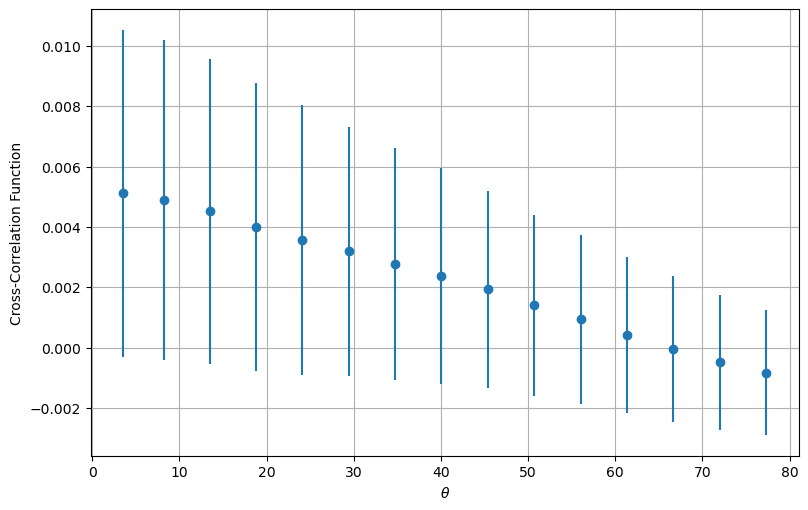

In [72]:
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr

def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  data = data[data['v'] > 1200]  # Filter out galaxies with negative cz values

  # Create ks column for K-band absolute magnitude
  from astropy.constants import c
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
  comoving_dist = cosmo.comoving_distance((data['v']*u.km/u.s)/c) 
  data['ks']  = data['k_tc'] - 25 - 5*np.log10(comoving_dist.value*(1 + (data['v']*u.km/u.s)/c))  # K-band absolute magnitude

  data['_RAJ2000'] = data['RAdeg']  
  data['_DEJ2000'] = data['DECdeg']  
  data['cz'] = data['v']

  return data

"""
READ DATA
"""
# === Load galaxy catalogue ===
gxs = read_catalog()
gxs = gxs[(gxs['cz']>1200)&(gxs['cz']<2400)]  

# === Load flux cataloge ===
# Load flux data
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

"""
CREATE CATALOGS
"""

gcat = treecorr.Catalog(ra=gxs['_RAJ2000'], dec=gxs['_DEJ2000'],\
                            ra_units='deg', dec_units='deg', npatch=10)

# Ensure flux_val is a valid 1D array
flux_val = np.array(flux_val, dtype=float)  # Convert to float if necessary

fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,\
                            ra_units='deg', dec_units='deg', npatch=10)

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    rand_ra = np.random.uniform(0, 360, N_total)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))
    return rand_ra, rand_dec

rand_ra, rand_dec = generate_RanCat(len(gxs)*10, dec_min=-90, dec_max=45)
rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                             ra_units='deg', dec_units='deg', npatch=10)

"""
CALCULATE CORRELATIONS
"""
config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 500,
}
nk = treecorr.NKCorrelation(config)
rk = treecorr.NKCorrelation(config)
nk.process(gcat, fcat)
rk.process(rand_cat, fcat)
xi, varxi = nk.calculateXi(rk=rk)
print('xi:', xi)
print('variance:', varxi**0.5)

"""
PLOT
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.errorbar(nk.meanr, xi, yerr=nk.raw_varxi**.5, fmt='o', label='Galaxy-Flux Correlation')
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\theta$')
plt.ylabel('Cross-Correlation Function')
plt.show()

### Calculando para distintos cz

Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']
The following patch numbers have no objects: {42, 83, 44}
This may be a problem depending on your use case.
The following patch numbers have no objects: {36, 46, 47, 83, 84}
This may be a problem depending on your use case.
The following patch numbers have no objects: {68, 69, 43, 24, 89}
This may be a problem depending on your use case.


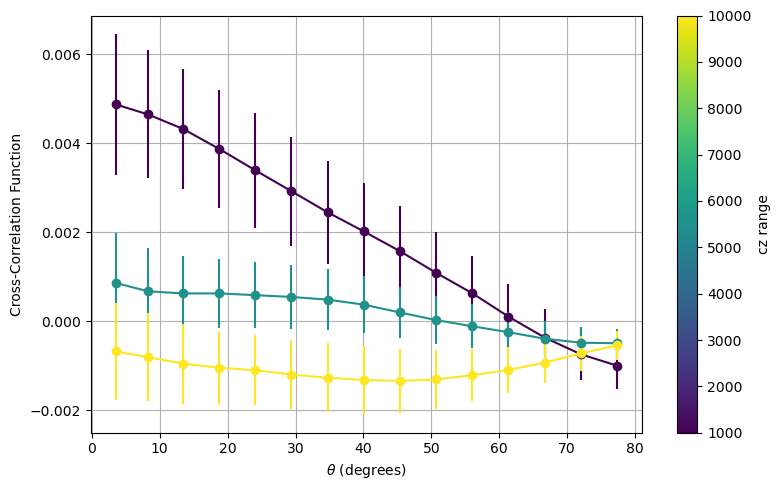

In [4]:
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt


def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  data = data[data['v'] > 1200]  # Filter out galaxies with negative cz values

  # Create ks column for K-band absolute magnitude
  from astropy.constants import c
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
  comoving_dist = cosmo.comoving_distance((data['v']*u.km/u.s)/c) 
  data['ks']  = data['k_tc'] - 25 - 5*np.log10(comoving_dist.value*(1 + (data['v']*u.km/u.s)/c))  # K-band absolute magnitude

  data['_RAJ2000'] = data['RAdeg']  
  data['_DEJ2000'] = data['DECdeg']  
  data['cz'] = data['v']

  return data

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    rand_ra = np.random.uniform(0, 360, N_total)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))
    return rand_ra, rand_dec

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
gxs = read_catalog()

# Validate gxs catalog
required_columns = ['_RAJ2000', '_DEJ2000', 'cz']
for col in required_columns:
    if col not in gxs.colnames:
        raise ValueError(f"Missing required column '{col}' in galaxy catalog.")

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=100)

"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
cz_slices = [(cz, cz + 3000) for cz in range(1000, 10000, 3000)]
colors = plt.cm.viridis(np.linspace(0, 1, len(cz_slices)))  # Color gradient

fig, ax = plt.subplots(figsize=(8, 5))

for i, (cz_min, cz_max) in enumerate(cz_slices):
    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['cz'] > cz_min) & (gxs['cz'] <= cz_max)]

    # Check if the slice has data
    if len(gxs_slice) == 0:
        print(f"No galaxies found in cz range {cz_min} < cz <= {cz_max}")
        continue

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=100)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    # Plot with color gradient
    plt.errorbar(nk.meanr, xi, yerr=varxi**.5, fmt='o-', color=colors[i],
                 label=f'{cz_min} < cz <= {cz_max}')

# Add colorbar using a dummy ScalarMappable
norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # dummy array
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel('Cross-Correlation Function')
ax.grid()
plt.tight_layout()
plt.show()